# MNIST dataset which contains 70,000 small images  of  digits handwritten. This is considered the Hello World  of Machine Learning. In this project we will implement a classification algorithm

In [1]:
import numpy as np
import os
%matplotlib inline
import  matplotlib as mpl
import matplotlib.pyplot as plt # to plot pretty figures
np.random.seed(42)
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [2]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [3]:
mnist.data.shape # ok we got what we need to start this project up now 

(70000, 784)

In [4]:
mnist.target 

array([0, 0, 0, ..., 9, 9, 9], dtype=int8)

In [5]:
X,y = mnist['data'],mnist['target']

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

# 70,000 images and each image has 784 features. This is because each image 
# is 28 x 28 and each feature represents one pixels intensity from 0(white) to 
# 255(black)

In [8]:
some_digit = X[36000]

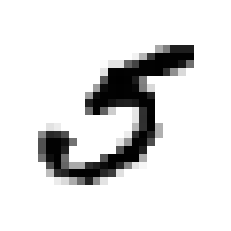

In [9]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap = matplotlib.cm.binary,interpolation='nearest')
plt.axis('off')
plt.show()

In [10]:
X_train, X_test, y_train , y_test = X[:60000], X[60000:], y[:60000],y[60000:]

In [11]:
X_train.shape

(60000, 784)

In [12]:
X_test.shape

(10000, 784)

In [13]:
# WE need to shuffle the training set , this will guarantee that all cross validation  folds will be similiar
# We dont want a fold to be missing some data

In [14]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Lets simplify the problem for now and only try to identify one digit for ex the number 5. This 5 detector will be an example of a BINARY CLASSIFIER, capable of distinguishing between  two classes 5 and  not 5... lets create the target vectors for this classification task.

In [15]:
y_train_5 = (y_train==5) # True for all 5's false for all other digits 
y_test_5 = (y_test ==5)

#    # Stochastic Gradient Descent ... Classifier that relies on randomness amd computes a score based on a decision function and a threshold

In [16]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
# lets use it to predict / detect images of number 5 from earlier 

In [18]:
sgd_clf.predict([some_digit])

array([ True])

In [19]:
# WaLaa we successfully classified the image !

# PERFORMANCE MEASURES

In [20]:
# Evaluating a classifer is often trickier than evaluating a regressor and thats what we will focus on in this chapter 

# Measuring accuracy using cross-validation but lets implement stratifiedKfold because we want the folds to be representative of the sample.....


In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone # Clone does a deep copy of the model in an estimator without actually attached  data.It yields
# a new estimator with the same parameters that has not been fit on any data. it works with a group of estimators also 

In [22]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)# clones the estimator 
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)

    print(n_correct/len(y_pred))

0.9613
0.9635
0.9661


In [23]:
# lets use Regular K fold now and see what results we get ... remember Kfold partitions the data into smaller sets to avoid overfitting
# k refers to the number of groups the data is split into to PREVENT OVER-fITTING 

In [24]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')


array([0.9613, 0.9635, 0.9661])

# over 95 %  accuracy ( ratio of correct predictions ) on all cross validations scores we had 3 folds so we had 3 accuracy scores but this classifer appears to be good but it is not ... its just classifying every single image in the not 5 class.....

In [25]:
# This is why accuracy is generally not the preferred performance measure for classifiers ,especially with skewed data sets 
# a much better way to evaluate the performance of a classifier is to look at the CONFUSION MATRIX 

# To compute the confusion Matrix , we need a set of predictions so they can be compared to the actual targets. Use cross_val_predict instead of score because instead of returning the evulation scores it returns the actually predicted values ....

In [26]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [27]:
# just pass the Target class (y_train_5)and the predicted classes (y_train_pred)

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[54122,   457],
       [ 1725,  3696]], dtype=int64)

In [29]:
###  The first row of this matrix considers non-5 images (the nega‐
# tive class): 54,122 of them were correctly classified as non-5s (they are called true
# negatives), while the remaining 457 were wrongly classified as 5s (false positives).
# The second row considers the images of 5s (the positive class): 1,725 were wrongly
# classified as non-5s (false negatives), while the remaining 3696 were correctly classi‐
# fied as 5s (true positives)

In [30]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)#3696+457=4153 3696/4153=.8895  TP/TP+FP


0.8899590657356128

# Recall is also known as true Positive rate  TP/TP+FN

In [31]:
recall_score(y_train_5,y_train_pred) # TP / TP + FN = 3696+1725= 5421.... 3696/5421 = .681793

0.6817930271167681

In [32]:
y_train_5.shape, y_train_pred.shape

((60000,), (60000,))

# F1 SCORE is the Weighted Average of the precision and recall , it reaches its best value at 1 and worst at 0

In [33]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7720910800083559

# The F1 score favors classifiers that have similiar precision and recall. but this is not what you always want in some contexts we only care for precision and in other situations you only care about recall.

In [34]:
# unfortunately we cant have it both ways increasing precision reduces recall and vice versa and this ladies and gentleman is called....\
# PRECISION/RECALL trade off........

In [35]:
y_scores = sgd_clf.decision_function([some_digit])

In [36]:
y_scores# Returns the score for each instance when you use decision function method above 

array([5220.50278623])

In [37]:
threshold = 0 

In [38]:
y_some_digit_pred = (y_scores>threshold)

In [39]:
y_some_digit_pred

array([ True])

In [40]:
threshold = 200000
y_some_digit_pred= (y_scores>threshold)
y_some_digit_pred

array([False])

In [41]:
# see when we raise the thresh hold it decreases the recall .. see the image  represents a 5 but when the threshold is raised 
# it miss classifies the digit 

# to decide which thresh hold to use we need to get all the scores from the instances in the training set using the cross_val_predict() function but this time specify the paramater method with "decision_function" instead of predictions now with these scores you can compute precision and recall  for all possible thresh holds using the precision_recall_curve() function 

In [42]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,
                               method='decision_function')

In [43]:
y_scores.shape # with these scores you can compute precision , recall for all possible thresholds

(60000,)

In [44]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

# ACCURACY OF THE POSITIVE PREDICTIONS IS CALLED PRECISION!

In [45]:
precisions,recalls, thresholds

(array([0.09077665, 0.09076142, 0.09076294, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
        3.68935621e-04, 1.84467810e-04, 0.00000000e+00]),
 array([-76477.36112955, -76469.61996907, -76426.0521032 , ...,
         28962.34363616,  29088.93503157,  32733.92922616]))

In [46]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],'b--',label='Precision')
    plt.plot(thresholds,recalls[:-1],'g-',label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

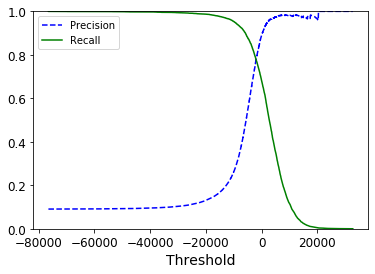

In [47]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [48]:
# Recall  can only go down when the threshold is increased  which explains why its curve looks smooth 

# Now you can select  the threshold  value  that gives you  the best precision/recall trade off for your task .Another way to select a good precision/recall tradeoff is to plot precision directly against recall 

# The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate. the ROC curve plots sensitivity (recall) versus 1- specificity 

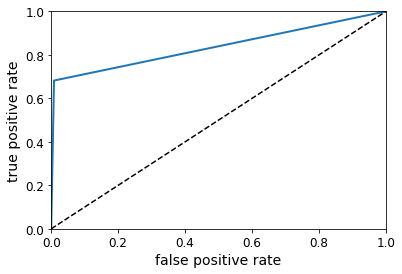

In [49]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_train_pred)
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
plot_roc_curve(fpr,tpr)
plt.show()

In [50]:
y_train_5.shape

(60000,)

In [51]:
y_scores.shape

(60000,)

# One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC. As a ruleof thumb, you should prefer the PR curve whenever the positiveclass is rare or when you care more about the false positives thanthe false negatives, and the ROC curve otherwise. For example,looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostlybecause there are few positives (5s) compared to the negatives(non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the topright corner).

# Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier. First, you need to get scores for each instance in the training set. But due to the way it works (see Chapter 7), the RandomForestClassifier class does not have a decision_function() method. Instead it has a predict_proba() method. Scikit-Learn classifiers generally have one or the other. Thepredict_proba() method returns an array containing a row per instance and a columnper class, each containing the probability that the given instance belongs to thegiven class (e.g., 70% chance that the image represents a 5):

In [52]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train,y_train_5,cv=3,method='predict_proba')

C:\Users\computer\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\computer\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\computer\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [53]:
# But to plot a ROC curve, you need scores, not probabilities. A simple solution is to
# use the positive class’s probability as the score:

C:\Users\computer\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


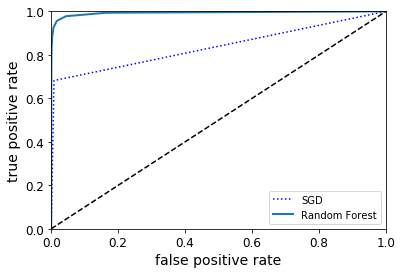

In [54]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr,tpr,'b:',label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,'Random Forest')
plt.legend(loc="bottom right")
plt.show()

In [55]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores_forest)


0.9931243366003829

# Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers.

# Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO).

In [56]:
    sgd_clf.fit(X_train,y_train)
    sgd_clf.predict([some_digit])

array([5], dtype=int8)

# That was easy! This code trains the SGDClassifier on the training set using the originaltarget classes from 0 to 9 (y_train), instead of the 5-versus-all target classes(y_train_5). Then it makes a prediction (a correct one in this case). Under the hood,Scikit-Learn actually trained 10 binary classifiers, got their decision scores for theimage, and selected the class with the highest score.

In [57]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -8204.47519778, -19206.28224706,  -5702.10113982,
         -4666.3653033 , -15827.7809826 ,   1782.52380291,
        -39807.3747045 , -18945.8333413 , -14650.34384565,
        -16166.06981109]])

# To see that this is indeed the case, you can call the decision_function() method. Instead of returning just one score per instance, it now returns 10 scores, one per class:

In [58]:
np.argmax(some_digit_scores)#The highest score is indeed the one corresponding  to class 5:

5

# When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value. In this case, the index of each class in the classes_ array conveniently matches the class itself (e.g., the class at index 5 happens to be class 5), but in general you won’t be so lucky. 

In [59]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

# If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a binary classifier to its constructor. For example, this code creates a multiclass classifier using the OvO strategy, based on a SGDClassifier:

In [60]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [61]:
len(ovo_clf.estimators_)

45

In [62]:
# Training a RandomForestClassifier is just as easy:
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

C:\Users\computer\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=int8)

# This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes. You can call predict_proba() to get the list of probabilities that the classifier assigned to each instance for each class:

In [63]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

You can see that the classifier is fairly confident about its prediction: the 0.8 at the 5th
index in the array means that the model estimates an 80% probability that the image represents a 5

In [64]:
# we Can evaluate these classifiers with cross validation 
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.86762647, 0.88469423, 0.8306746 ])

# It gets over 84% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. For example, simply scaling the inputs (as discussed in Chapter 2) increases accuracy above 90%:

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

C:\Users\computer\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\computer\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89982004, 0.90534527, 0.90153523])

# First, you can look at the confusion matrix. You need to make predictions using the cross_val_predict() function, then call the confusion_matrix() function, just like you did earlier:

In [66]:
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx
    

array([[5697,    1,   24,   30,   21,   48,   22,    3,   72,    5],
       [   2, 6095,   42,   30,   10,   20,   11,   17,  500,   15],
       [  66,   78, 5013,  208,   59,   39,   94,   69,  317,   15],
       [  45,   20,  103, 5336,   16,  148,   10,   49,  354,   50],
       [  16,   26,   48,   24, 5373,   26,   34,   23,  132,  140],
       [ 106,   18,   39,  359,   66, 4013,   67,   26,  664,   63],
       [  64,   16,   80,   20,   55,  149, 5411,    0,  122,    1],
       [  46,   22,   61,   63,   90,   20,    4, 5490,  192,  277],
       [  67,  125,   61,  522,   56,  318,   25,   32, 4555,   90],
       [  38,   23,   32,  164,  328,   70,    3,  258,  356, 4677]],
      dtype=int64)

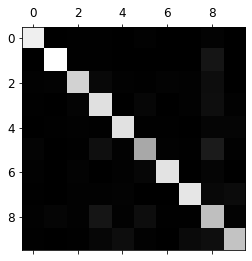

In [67]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

# Let’s focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors (which would make abundant classes look unfairly bad):

In [68]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
norm_conf_mx


array([[9.61843660e-01, 1.68833361e-04, 4.05200068e-03, 5.06500084e-03,
        3.54550059e-03, 8.10400135e-03, 3.71433395e-03, 5.06500084e-04,
        1.21560020e-02, 8.44166807e-04],
       [2.96647879e-04, 9.04034411e-01, 6.22960546e-03, 4.44971818e-03,
        1.48323939e-03, 2.96647879e-03, 1.63156333e-03, 2.52150697e-03,
        7.41619697e-02, 2.22485909e-03],
       [1.10775428e-02, 1.30916415e-02, 8.41389728e-01, 3.49110440e-02,
        9.90265190e-03, 6.54582075e-03, 1.57771064e-02, 1.15810675e-02,
        5.32057737e-02, 2.51762336e-03],
       [7.33974882e-03, 3.26211059e-03, 1.67998695e-02, 8.70331104e-01,
        2.60968847e-03, 2.41396183e-02, 1.63105529e-03, 7.99217093e-03,
        5.77393574e-02, 8.15527646e-03],
       [2.73878809e-03, 4.45053064e-03, 8.21636426e-03, 4.10818213e-03,
        9.19719274e-01, 4.45053064e-03, 5.81992468e-03, 3.93700787e-03,
        2.25950017e-02, 2.39643958e-02],
       [1.95535879e-02, 3.32042059e-03, 7.19424460e-03, 6.62239439e-02,
   

# Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result

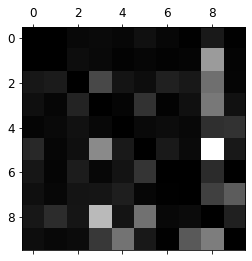

In [69]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

NOW we can clearly see the mistakes the classifier makes.......

In [70]:
# REMEMBER ROWS ACTUALLY REPRESENT CLASSES  AND COLUMNS REPRESENT PREDICTED CLASSES

In [71]:
# The columns for 8 and 9 are very bright which tell you that many images get misclassified as 8 and 9
# but as u can see row is very dark  , this means the digit 1 is classified correctly and a few got confused with 8
# notice the errors are not completely symmetrical 

# it seems that your efforts should be spent on improving classification of 8s and 9s, as well as fixing the specific 3/5 confusion. For example, you could try to gather more training data for these digits. Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops. Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming. For example, let’s plot examples of 3s and 5s:

In [72]:
#most misclassified images seem like obvious errors to us,
# and it’s hard to understand why the classifier made the mistakes it did. The reason is
# that we used a simple SGDClassifier, which is a linear model. All it does is assign a
# weight per class to each pixel, and when it sees a new image it just sums up the weighted
# pixel intensities to get a score for each class. So since 3s and 5s differ only by a few
# pixels, this model will easily confuse them.


# In other words, this classifier is quite sensitive to image shifting and rotation. So one way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated. This will probably help reduce other errors as well.

# MULTILABEL CLASSIFICATION

In [73]:
# a classification system that outputs multiple binary labels is called a multilabel classification system.

In [74]:
#examplE
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >=7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large,y_train_odd] #<<<<<<<<<<<<<<<< Description below ............
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


# It concats your first array into the last dimension (axis) of your last array in the function.a = array([[1, 2, 3], [4, 5, 6]])b = array([[7, 8, 9], [10, 11, 12]])First, let's look at the shape:The shape of both a and b are (2, 3). Concating a (2, 3) into the last axis of b (3), while keeping other axises unchanged (1) will become (2, 3 + 3) = (2, 6)

# np.c_ description Above 

In [75]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [76]:
# INDEEED THIS IS CORRECT 5 is not larger or equal to 7 and it is a odd number  ( %2 ==1 )

# There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. For example, one approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. This code computes the average F1 score across all labels:

In [77]:
# REMEMBER THE f1 score is the weighted average of precision and recall which is True Positive / TP + 1/2(FP+FN)
# CROSS VALIDATION IS A RESAMPLING PROCEDURE USED TO EVALUATE MACHINE LEARNING MODELS ON LIMITED SAMPLE DATA The procedure 
# is called k-fold cross validation

In [78]:
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_train,cv=3)
f1_score(y_train,y_train_knn_pred,average='macro')#<<<<<<< below describes this hyper parameter........

0.9684554018028022

# Micro- and macro-averages (for whatever metric) will compute slightly different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).# 

# This assumes that all labels are equally important, which may not be the case. In particular,if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. One simple option is to give each label a weight equal to its support (i.e., the number of instances with thattarget label). To do this, simply set average="weighted" in the preceding code.

# EXCERCISE 1
# verbose=3 option that allows to see loss and accuracy per batch 

# MNIST CLASSIFIER with OVER 97 % accuracy

In [79]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'weights':['uniform','distance'],'n_neighbors':[3,4,5]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf,param_grid,cv=5,verbose=3,n_jobs=-1)# n_jobs is to specifiy how many cores you wonna run 
grid_search.fit(X_train,y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 283.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [80]:
grid_search.best_score_

0.97325

In [81]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [82]:
from sklearn.metrics import accuracy_score 
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

# 